In [1]:
import pyspark.sql.functions as fn
import pyspark.sql.types
from pyspark.sql import SparkSession
from pyspark.sql.types import *

In [2]:
# 1. Filters years from 2005-2020
# 2. Unbucketize the columns
# 3. Filters chosen countries
def filterCountryData(df,countries_chosen):
    
    # range b/w 2005-2020
    years = list(map(lambda x: str(x),list(range(2005,2021,1)))) 
    
    cols =["Country Name","Country Code","Indicator Name","Indicator Code"]+years
    country_2005_20 = df.select(cols)
    
    
    # filters countries chosen and fills any missing year values with 0.00
    ts = "2020-04-01"
    countries_chosen_2005_20 = (country_2005_20
                                .filter(fn.col("Country Name").isin(countries_chosen)).fillna(0.00, subset=years)
                                .withColumn("date",fn.date_format(fn.lit(ts),"yyyy-MM-dd"))
                               )
    
    #unbucketize the data
    unpivotStr= list(map(lambda x: " '{t}',`{t}`".format(t=x),years))
    sep = ','
    unpivotExpr = "stack("+str(len(years))+", "+sep.join(unpivotStr)+") as (Year, Value)"
    columns_without_years= set(countries_chosen_2005_20.columns ) - set(years)
    
    res = countries_chosen_2005_20.select(
        "Country Name",
        "Country Code",
        "Indicator Name",
        fn.expr(unpivotExpr),
        fn.month("date").alias("month"),
        fn.dayofmonth("date").alias("day"),
        fn.quarter("date").alias("quarter")            
    )
    
    #TODO: join the dimensions to make a fact table

    return res

In [3]:
# Date Dimension
def generate_dates(spark,range_list,interval=60*60*24,dt_col="date_time_ref"): # TODO: attention to sparkSession
     """
     Create a Spark DataFrame with a single column named dt_col and a range of date within a specified interval (start and stop included).
     With hourly data, dates end at 23 of stop day

     :param spark: SparkSession or sqlContext depending on environment (server vs local)
     :param range_list: array of strings formatted as "2018-01-20" or "2018-01-20 00:00:00"
     :param interval: number of seconds (frequency), output from get_freq()
     :param dt_col: string with date column name. Date column must be TimestampType

     :returns: df from range
     """
     start,stop = range_list
     temp_df = spark.createDataFrame([(start, stop)], ("start", "stop"))
     temp_df = temp_df.select([fn.col(c).cast("timestamp") for c in ("start", "stop")])
     temp_df = temp_df.withColumn("stop",fn.date_add("stop",1).cast("timestamp"))
     temp_df = temp_df.select([fn.col(c).cast("long") for c in ("start", "stop")])
     start, stop = temp_df.first()
     return spark.range(start,stop,interval).select(fn.col("id").cast("timestamp").alias(dt_col))


def dateDimension():
    time_rng = ["2005-01-01","2020-12-31"]
    year_df= generate_dates(spark,time_rng)
    tmp = (year_df
           .withColumn("year",fn.year("date_time_ref"))
           .withColumn("month",fn.month("date_time_ref"))
           .withColumn("day",fn.dayofmonth("date_time_ref"))
           .withColumn("quarter",fn.quarter("date_time_ref"))
           .withColumn("decade",
                          fn.when(fn.col("year") % 10 >=5,fn.col("year")-fn.col("year")%10+10)
                              .otherwise(fn.col("year")- fn.col("year") % 10))
           .withColumn("year_code",fn.monotonically_increasing_id())

          )
    date_dim = (tmp
                   .select(tmp.year_code,*set(tmp.columns)-set(["year_code"]))
               )
    
    return date_dim

In [133]:
def naturalDisasterDim(df,filePath,countries_chosen):
    """
        creates natural disaster dimension + look up table
    
        df - date dataframe
        filePath - filePath to natural disaster csv
        countries_chosen - list of strings of countries to work on
    """
    
    columns = ["total deaths","Total Damages ('000 US$)"]
    
    # reads csv
    natural_disaster_df = (spark
                       .read
                       .format('csv')
                           .option("inferSchema",True)
                           .option("header",True)
                           .load(filePath)
                           .fillna(0.00,subset=columns)).dropDuplicates()
    

    # reconfigures column names + banding
    
    tmp_nd = (natural_disaster_df
                  # replaces United States of America -> united states
              .withColumn("Country",fn.when(fn.lower(fn.col("Country")).contains("united states"),"united states").otherwise(fn.lower(fn.col("Country"))))
              .withColumn("start_month",fn.col("Start Month"))
                  .withColumn("start_year",fn.col("Start Year"))
                  .withColumn("start_day",fn.col("Start Day"))
                  .withColumn("end_month",fn.col("End Month"))
                  .withColumn("end_year",fn.col("End Year"))
                  .withColumn("end_day",fn.col("End Day"))
              .withColumn("disaster_type",fn.col("Disaster Type"))
              .withColumn("disaster_subtype",fn.col("disaster subtype"))
              .withColumn("disaster_nestedsubtype",fn.col("disaster subsubtype"))
              .withColumn("disaster_subgroup",fn.col("disaster subgroup"))
              .withColumn("event_name",fn.col("event name"))
              .withColumn("ofda_response",fn.col("ofda response"))
              .fillna(1.0,["start_day","start_month","start_year","end_day","end_month","end_year"])
              .fillna("Not Available",["disaster_type","disaster_subtype","disaster_nestedsubtype","disaster_subgroup","event_name","ofda_response"])
              .withColumn("ttl_death",
                          # range (low,medium, high)
                          fn.when(fn.col("total deaths")>7000,
                                  fn.when(fn.col("total deaths")>14000,"high").otherwise("medium")).otherwise("low")
                         )
              .withColumn("ttl_damages",
                          # 
                          fn.when(fn.col("Total Damages ('000 US$)")>1000000,
                                  fn.when(fn.col("Total Damages ('000 US$)")>100000000,"high").otherwise("medium")).otherwise("low")
                         )
              
                  .drop("year")
             )

    # join on start year
    
    max_year = df.select(fn.max("year")).limit(1).collect()[0][0]
    min_year = df.select(fn.min("year")).limit(1).collect()[0][0]
    
    nd_j_on_date = tmp_nd.filter(fn.col("start_year")>=min_year).filter(fn.col("end_year")<=max_year)

    # filter countries chosen
    filtered_byCountry_date = (nd_j_on_date
           .filter(fn.col("Country").isin(list(map(lambda x: x.lower(),countries_chosen))))
           
    )
    
    # distinct banded rows with key
    res = (filtered_byCountry_date  
                                  .select([
                                           "disaster_type",
                                           "disaster_subtype",
                                           "disaster_nestedsubtype",
                                           "disaster_subgroup",
                                           "event_name",
                                           "ttl_death",
                                           "ttl_damages",
                                           "ofda_response"])                                   
                                 ).distinct().withColumn("natural_disaster_key",fn.monotonically_increasing_id())
    
    
    lookup=(res.join(
        filtered_byCountry_date,
        on = [
            "disaster_type","disaster_subtype","disaster_nestedsubtype","disaster_subgroup","event_name","ofda_response","ttl_damages","ttl_death"
        ])
        .select("natural_disaster_key","Country","start_year","start_month","start_day","end_year","end_month","end_day")
        )
    
    
    # dimension, lookup
    return res,lookup

naturalDisasterDimension, nd_lookup=naturalDisasterDim(
    dateDim,
    countries_chosen=countries_chosen,
    filePath="AssignmentData/ExternalSources/DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv"
)

display(naturalDisasterDimension.toPandas())
display(nd_lookup.toPandas())

,disaster_type,disaster_subtype,disaster_nestedsubtype,disaster_subgroup,event_name,ttl_death,ttl_damages,ofda_response,natural_disaster_key
0,Earthquake,Ground movement,Not Available,Geophysical,Not Available,low,medium,Yes,0
1,Storm,Tropical cyclone,Not Available,Meteorological,Hurricane Irene,low,low,Not Available,1
2,Storm,Tropical cyclone,Not Available,Meteorological,Tropical storm Hermine,low,low,Not Available,2
3,Storm,Tropical cyclone,Not Available,Meteorological,Tropical storm 'Vicente',low,low,Not Available,3
4,Storm,Tropical cyclone,Not Available,Meteorological,John,low,low,Not Available,8589934592
...,...,...,...,...,...,...,...,...,...
243,Storm,Tropical cyclone,Not Available,Meteorological,Hurricane 'Zeta',low,low,Not Available,1700807049216
244,Storm,Tropical cyclone,Not Available,Meteorological,Hurricane 'Matthew',low,medium,Not Available,1700807049217
245,Drought,Drought,Not Available,Climatological,Not Available,high,low,Not Available,1700807049218
246,Earthquake,Ground movement,Not Available,Geophysical,Not Available,low,low,Not Available,1709396983808


,natural_disaster_key,Country,start_year,start_month,start_day,end_year,end_month,end_day
0,1537598291968,united states,2006,8,2,2006,9,7
1,1279900254208,mexico,2013,9,5,2013,9,8
2,1279900254208,united states,2013,12,22,2013,12,31
3,1554778161152,mexico,2015,5,25,2015,5,26
4,1279900254208,mexico,2017,9,26,2017,10,7
...,...,...,...,...,...,...,...,...
803,1709396983808,japan,2014,11,22,2014,11,22
804,1503238553600,mexico,2016,9,29,2016,10,5
805,223338299393,japan,2017,10,22,2017,10,22
806,1168231104512,united states,2020,11,10,2020,11,10


In [3]:
def educationDim(df,filePath,countries_chosen,countryDF):\
    
    #read data frame (Might be irrelevant)\n"
    education_df = (spark.read
                    .format('csv')
                    .option("inferSchema",True)
                    .option("header",True)
                    .load(filePath))
    #Select the relevant indicators for this dimension\n",
    indicators_chosen = ["Primary completion rate, total (% of relevant age group)", "School enrollment, primary (% net)",
                         "School enrollment, secondary (% net)", "School enrollment, tertiary (% gross)",
                         "Literacy rate, adult total (% of people ages 15 and above)",
                         "Literacy rate, youth total (% of people ages 15-24)"]
    #Seperate the Indicator Name column into its seperate relevant indicators\n",
    education_table = countryDF.groupBy("Country Name","Year").pivot("Indicator Name",indicators_chosen).sum("Value")
    display(education_table.orderBy(fn.asc("Year")).toPandas())

    #TODO Create Lookuptable\n",
    return education_table, b
    #TODO remove this test code\n",
    educationDimension, edu_lookup=educationDim(
        dateDim,
        countries_chosen=countries_chosen,
        filePath="AssignmentData/ExternalSources/DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv",
        countryDF=filterdCountryDf)

In [5]:
# def countryDimension(df,countries_chosen):
    
#     tmp = (df
#                .filter(fn.lower(fn.col("Country")).isin(list(map(lambda x: x.lower(),countries_chosen))))
#                .withColumn("")
           
    

In [6]:
spark = SparkSession.builder.appName("ds_datastage").getOrCreate()

In [81]:
#MAIN block
countries_chosen = ["United States", "Canada","Mexico","Thailand","Finland","Nigeria","Somalia","Norway","Japan"]



df=spark.read.format("csv").option("header",True).option("inferSchema",True).load("AssignmentData/HNP_StatsData.csv")

#filtered data
# filterdCountryDf=filterCountryData(df,countries_chosen)
dateDim = dateDimension()
naturalDisasterDimension, nd_lookup=naturalDisasterDim(
    dateDim,
    countries_chosen=countries_chosen,
    filePath="AssignmentData/ExternalSources/DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv"
)
# countryDimension = 

# display(filterdCountryDf.toPandas())
# display(dateDim.toPandas())


295119


,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,...,end_day,disaster_type,disaster_subtype,disaster_nestedsubtype,disaster_subgroup,event_name,ttl_death,ttl_damages,ofda_response,natural_disaster_key
0,316,None,Natural,Meteorological,Storm,Tropical cyclone,None,Hurricane 'Hanna',mexico,MEX,...,26.0,Storm,Tropical cyclone,,Meteorological,Hurricane 'Hanna',low,low,None,0
1,297,None,Natural,Climatological,Wildfire,Forest fire,None,Clayton Fire,united states,USA,...,16.0,Wildfire,Forest fire,,Climatological,Clayton Fire,low,low,None,8589934592
2,421,None,Natural,Meteorological,Storm,Tropical cyclone,None,Tropical storm 'Vicente',mexico,MEX,...,23.0,Storm,Tropical cyclone,,Meteorological,Tropical storm 'Vicente',low,low,None,17179869184
3,434,None,Natural,Climatological,Wildfire,"Land fire (Brush, Bush, Pasture)",None,"Tubbs, Atlas, Nuns Fires",united states,USA,...,31.0,Wildfire,"Land fire (Brush, Bush, Pasture)",,Climatological,"Tubbs, Atlas, Nuns Fires",low,medium,None,25769803776
4,665,None,Natural,Biological,Epidemic,Parasitic disease,None,None,somalia,SOM,...,NaN,Epidemic,Parasitic disease,,Biological,,low,low,None,51539607552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,124,None,Natural,Hydrological,Flood,Flash flood,None,None,united states,USA,...,19.0,Flood,Flash flood,,Hydrological,,low,medium,None,1649267441665
244,513,None,Natural,Climatological,Wildfire,Forest fire,None,Saddleridge fire & Sandalwood fire,united states,USA,...,17.0,Wildfire,Forest fire,,Climatological,Saddleridge fire & Sandalwood fire,low,low,None,1666447310848
245,320,None,Natural,Geophysical,Earthquake,Tsunami,None,None,japan,JPN,...,10.0,Earthquake,Tsunami,,Geophysical,,low,low,None,1675037245440
246,358,None,Natural,Meteorological,Storm,Tropical cyclone,None,Hurricane Manuel,mexico,MEX,...,20.0,Storm,Tropical cyclone,,Meteorological,Hurricane Manuel,low,medium,Yes,1683627180032


,natural_disaster_key,Country,start_year,end_year,start_month,end_month,start_day,end_day
0,1434519076864,mexico,2006,2006,10,10,25,28
1,1434519076864,mexico,2006,2006,10,10,25,28
2,1434519076864,mexico,2006,2006,10,10,25,28
3,1434519076864,mexico,2006,2006,10,10,25,28
4,1434519076864,mexico,2006,2006,10,10,25,28
...,...,...,...,...,...,...,...,...
84369,1494648619009,united states,2005,2005,9,10,23,1
84370,1494648619009,united states,2005,2005,9,10,23,1
84371,1494648619009,united states,2005,2005,9,10,23,1
84372,1494648619009,united states,2005,2005,9,10,23,1


In [48]:

### TESTING BLOCK


# ## LOOKUP TABLE LOGIC
# # 2006-2010
# tmp = dateDim.filter(fn.col("year")==2006).select(fn.col("year").alias("year_2"))
# dateDim_a = dateDim.alias("a")
# tmp_b = tmp.alias("b")

# test2 = dateDim_a.join(tmp_b.alias("b"),tmp_b.year_2<dateDim_a.year)
# test3 = dateDim_a.join(tmp_b.alias("b"),2010>dateDim_a.year)

# test2.show()
# test3.show()

# test3.intersect(test2).show()

df = spark.parallelize([ \

    Row(name='Alice', age=5, height=80), \

    Row(name='Alice', age=5, height=80), \

    Row(name='Alice', age=10, height=80)]).toDF()


AttributeError: 'SparkSession' object has no attribute 'parallelize'

In [9]:
### TEST FUNCTIONS

import matplotlib.pyplot as plt 
import numpy as np

# df - dataframe
# col - column to observe
def nullCount(df,cl):
    non_null =(df
     .filter(fn.col(cl).isNotNull())
     .select(fn.col(cl))
     .groupBy(fn.col(cl))
     .count()
     .sort(fn.col(cl).asc())
    )
    
    
    null = (df
        .filter(fn.col(cl).isNull()))
    
    print("Number of non null values: "+str(non_null.count()))
    print("Number of null values: "+str(null.count()))
    
    
def summary_df(df,cl,bns = 10):
    """
        returns null counts, basic statistics & plot of current values in a column
        
        df - dataframe you wish to observer these statistics
        cl - column of which you wish to observe
        bns - bins (number of bars) histogram will try to bucketize data in
    """
    nullCount(df,cl)
    
    tmp = df.filter(fn.col(cl).isNotNull())
    tmp.select(cl).describe().show()

    pd_data = tmp.select(fn.col(cl)).toPandas()
    # display(pd_data)
    plt.hist(pd_data,bins = bns)
    plt.title("Histogram of " +str(cl))
    plt.xlabel(cl)
    plt.ylabel("count")

Number of non null values: 184
Number of null values: 0
+-------+------------------------+
|summary|Total Damages ('000 US$)|
+-------+------------------------+
|  count|                  295119|
|   mean|      1620193.3077470444|
| stddev|       9949490.043950472|
|    min|                       0|
|    max|               210000000|
+-------+------------------------+



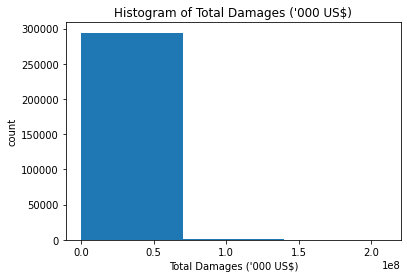

In [10]:
#"Total Damages ('000 US$)"
summary_df(naturalDisasterDimension,"Total Damages ('000 US$)",bns=3)